# Orientation bias

It is known that redMaPPer preferentially selects clusters that are orientated with the major axis along the line of sight. Heidi Wu computed $\Delta\Sigma$ profiles of halos in simulations with aligned major axes in order to mimic this selection effect. In this notebook, I am going to look at some data that Heidi made, and create "modified" Y1 data vectors that have the orientation bias removed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
%matplotlib inline

In [2]:
plt.rc("font", size=14, family='serif')
plt.rc("text", usetex=True)
plt.rc("errorbar", capsize=3)

In [3]:
#Paths to Heidi's data (note: this data will soon be out of date)
def richness_selected_path(z_low, z_high, lambda_low, lambda_high):
    zl = ("%.2f"%(z_low)).rstrip("0")
    zh = ("%.2f"%(z_high)).rstrip("0")
    return "DS_orientation/DS_z_%s_%s_lam_%d_%d.dat"%(zl, zh, lambda_low, lambda_high)

def mass_selected_path(z_low, z_high, lambda_low, lambda_high):
    zl = ("%.2f"%(z_low)).rstrip("0")
    zh = ("%.2f"%(z_high)).rstrip("0")
    return "DS_orientation/DS_same_mass_redshift_distribution_z_%s_%s_lam_%d_%d.dat"%(zl, zh, lambda_low, lambda_high)

In [4]:
print(richness_selected_path(0.2, 0.35, 30, 40))
print(mass_selected_path(0.2, 0.35, 30, 40))

DS_orientation/DS_z_0.2_0.35_lam_30_40.dat
DS_orientation/DS_same_mass_redshift_distribution_z_0.2_0.35_lam_30_40.dat


In [5]:
def get_richness_selected_data(z_low, z_high, lambda_low, lambda_high):
    #Distances are Mpc/h comoving, mass is Msun/h
    return np.loadtxt(richness_selected_path(z_low, z_high, lambda_low, lambda_high)).T

def get_mass_selected_data(z_low, z_high, lambda_low, lambda_high):
    #Distances are Mpc/h comoving, mass is Msun/h
    return np.loadtxt(mass_selected_path(z_low, z_high, lambda_low, lambda_high)).T

In [6]:
def get_ratio(z_low, z_high, lambda_low, lambda_high):
    Rp1, DS1, err1 = get_richness_selected_data(z_low, z_high, lambda_low, lambda_high)
    Rp2, DS2, err2 =     get_mass_selected_data(z_low, z_high, lambda_low, lambda_high)
    Rp = np.mean((Rp1, Rp2), axis=0) #the two select
    X = DS1/ DS2
    Xerr = np.sqrt(err1**2/DS2**2 + err2**2*X**2/DS2**2)
    return Rp, X, Xerr

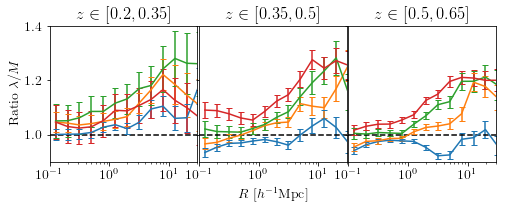

In [7]:
#Read in everything and visually check
zlos = [0.2, 0.35, 0.5]
zhis = [0.35, 0.5, 0.65]
lamlos = [20, 30, 40, 50]
lamhis = [30, 40, 50, 10000]

fig, axes = plt.subplots(ncols = 3, nrows = 1, sharex=True, sharey=True, figsize = (8,3))
plt.subplots_adjust(wspace = 0.01, bottom=0.25)
for zi, zlo in enumerate(zlos):
    zhi = zhis[zi]
    zl = ("%.2f"%(zlo)).rstrip("0")
    zh = ("%.2f"%(zhi)).rstrip("0")
    axes[zi].set_title(r"$z\in[%s, %s]$"%(zl, zh))
    axes[zi].axhline(1.0, color="k", ls="--")

    for lj, lamlo in enumerate(lamlos):
        lamhi = lamhis[lj]
        Rp, X, Xerr = get_ratio(zlo, zhi, lamlo, lamhi)
        axes[zi].errorbar(Rp, X, Xerr)
        axes[zi].set_xlim(0.1, 30)
        axes[zi].set_xscale('log')
        axes[zi].set_ylim(0.9, 1.4)
axes[1].set_xlabel(r"$R\ [h^{-1}{\rm Mpc}]$")
axes[0].set_ylabel(r"Ratio $\lambda / M$")
fig.savefig("ratio_of_data.png", dpi=300, bbox_inche='tight')

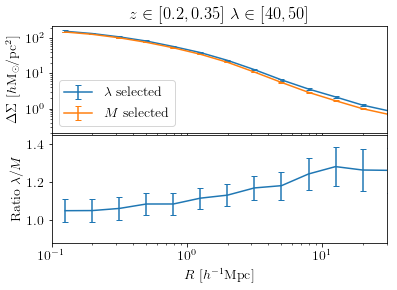

In [8]:
z_low = 0.2
z_high = 0.35
lam_low = 40
lam_high = 50
zl = ("%.2f"%(z_low)).rstrip("0")
zh = ("%.2f"%(z_high)).rstrip("0")
Rp1, DS1, err1 = get_richness_selected_data(z_low, z_high, lam_low, lam_high)
Rp2, DS2, err2 = get_mass_selected_data(z_low, z_high, lam_low, lam_high)
Rp, X, Xerr = get_ratio(z_low, z_high, lam_low, lam_high)

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)

ax[0].errorbar(Rp1, DS1, err1, label=r"$\lambda$ selected")
ax[0].errorbar(Rp2, DS2, err2, label=r"$M$ selected")
ax[0].legend(loc=0)
ax[1].errorbar(Rp, X, Xerr)
ax[0].loglog()
ax[0].set_xlim(.1, 30)
plt.subplots_adjust(hspace = 0.02)
ax[1].set_xlabel(r"$R\ [h^{-1}{\rm Mpc}]$")
ax[1].set_ylabel(r"Ratio $\lambda / M$")
ax[0].set_ylabel(r"$\Delta\Sigma\ [h{\rm M_\odot/pc^2}]$")
ax[0].set_title("$z\in[%s, %s]\ \lambda\in[%d, %d]$"%(zl, zh, lam_low, lam_high))
fig.savefig("single_bin_reproduction.png", dpi=300, bbox_inches='tight')

## Next step - modify DES data

This is good so far, since I can successfully reproduce Heidi's plots. The next step is to save these curves at the midpoints of the bins from the Y1 analysis. This will be replaced later when the simulated lensing profiles are computed in the same radial bins as the Y1 data.

In [9]:
h = 0.7 #reduced hubble constant assumed for Y1
z_mean_Y1 = np.loadtxt("Y1_meanz.txt")
#Physical distances!
Redges = np.logspace(np.log10(0.0323), np.log10(30.), num=15+1)
lnRedges = np.log(Redges)
#Rmid = (Redges[:-1] + Redges[1:])/2
Rmid = np.exp((lnRedges[:-1] + lnRedges[1:])/2) #take the mean in the log
lnRmid = (lnRedges[:-1] + lnRedges[1:])/2 #take the mean in the log

#THIS FUNCTION WILL GET REPLACED WHEN THE NEW DATA COMES OUT
def get_ratio_in_Y1_bins(z_low, z_high, lam_low, lam_high):
    zi = [0.2, 0.35, 0.5].index(z_low)
    lj = [20, 30, 40, 50].index(lam_low) #NOTE - must replace this line with new data

    Rp, X, Xerr = get_ratio(z_low, z_high, lam_low, lam_high)
    lnRp = np.log(Rp)
    X_spline = IUS(Rp, X, k=1)
    Xerr_spline = IUS(Rp, Xerr, k=1)
    #X_spline = IUS(lnRp, X)
    #Xerr_spline = IUS(lnRp, Xerr)

    z = z_mean_Y1[zi, lj+3]
    X_Y1 = X_spline(Rmid*h*(1+z)) #convert to Mpc/h comoving
    Xerr_Y1 = Xerr_spline(Rmid*h*(1+z))
    #X_Y1 = X_spline(lnRmid + np.log(h*(1+z))) #convert to Mpc/h comoving
    #Xerr_Y1 = Xerr_spline(lnRmid + np.log(h*(1+z)))
    return Rmid*h*(1+z), X_Y1, Xerr_Y1

In [10]:
#Loop over all bins and save the ratios\
zlos = [0.2, 0.35, 0.5]
zhis = [0.35, 0.5, 0.65]
lamlos = [20, 30, 40, 50]
lamhis = [30, 40, 50, 10000]

outpath = "X_ratios_for_Y1/X_ratio_z%d_l%d.txt"

In [11]:
for zi, zlo in enumerate(zlos):
    zhi = zhis[zi]
    for lj, lamlo in enumerate(lamlos):
        lamhi = lamhis[lj]
        Rp, X, Xe = get_ratio_in_Y1_bins(zlo, zhi, lamlo, lamhi)
        #print(X[-3:])
        output = np.array([Rp, X, Xe]).T
        np.savetxt(outpath%(zi,lj+3), output, header="R [Mpc/h comoving], X (lambda selected/mass selected), X error")
        print("Saved z%d l%d"%(zi, lj+3))

Saved z0 l3
Saved z0 l4
Saved z0 l5
Saved z0 l6
Saved z1 l3
Saved z1 l4
Saved z1 l5
Saved z1 l6
Saved z2 l3
Saved z2 l4
Saved z2 l5
Saved z2 l6


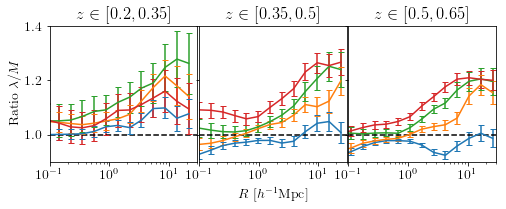

In [12]:
#Read in everything and visually check
zlos = [0.2, 0.35, 0.5]
zhis = [0.35, 0.5, 0.65]
lamlos = [20, 30, 40, 50]
lamhis = [30, 40, 50, 10000]

fig, axes = plt.subplots(ncols = 3, nrows = 1, sharex=True, sharey=True, figsize = (8,3))
plt.subplots_adjust(wspace = 0.01, bottom=0.25)
for zi, zlo in enumerate(zlos):
    zhi = zhis[zi]
    zl = ("%.2f"%(zlo)).rstrip("0")
    zh = ("%.2f"%(zhi)).rstrip("0")
    axes[zi].set_title(r"$z\in[%s, %s]$"%(zl, zh))
    axes[zi].axhline(1.0, color="k", ls="--")
    for lj, lamlo in enumerate(lamlos):
        lamhi = lamhis[lj]
        #Rp, X, Xerr = get_ratio_in_Y1_bins(zlo, zhi, lamlo, lamhi)
        Rp, X, Xerr = np.loadtxt(outpath%(zi,lj+3), unpack=True)
        axes[zi].errorbar(Rp, X, Xerr)
        axes[zi].set_xlim(0.1, 30)
        axes[zi].set_xscale('log')
        axes[zi].set_ylim(0.9, 1.4)
axes[1].set_xlabel(r"$R\ [h^{-1}{\rm Mpc}]$")
axes[0].set_ylabel(r"Ratio $\lambda / M$")
fig.savefig("ratio_from_splines_at_Y1_data.png", dpi=300, bbox_inche='tight')